In [1]:
# imports
import os
import torch

# local imports
from utils import (
    rollout2trajectory,
    compute_sensitivity,
    compute_batch_multistep_sensitivity,
    plot_matrix,
    plot_1d,
    plot_semilogy,
    plot_multistep_sensitivity,
)

In [2]:
# load policy
export_dir = "../logs/point_mass/2025-11-25_00-17-33/exported"
policy_path = os.path.join(export_dir, "policy_jit.pt")
rollout_path = os.path.join(export_dir, "rollout.pt")
io_path = os.path.join(export_dir, "policy_io.txt")
policy = torch.jit.load(policy_path).eval()
rollout = torch.load(rollout_path)
with open(io_path, "r") as f:
    print(f.read())
rollout_obs, rollout_actions = rollout2trajectory(rollout)
print(f"Rollout Data: {rollout_obs.numpy().shape}")

<ActionManager> contains 1 active terms.
+----------------------------------+
|  Active Action Terms (shape: 2)  |
+-------+--------------+-----------+
| Index | Name         | Dimension |
+-------+--------------+-----------+
|   0   | joint_effort |         2 |
+-------+--------------+-----------+

<ObservationManager> contains 1 groups.
+---------------------------------------------------+
| Active Observation Terms in Group: 'policy' (shape: (4,)) |
+--------------+---------------------+--------------+
|    Index     | Name                |    Shape     |
+--------------+---------------------+--------------+
|      0       | pose                |     (2,)     |
|      1       | velocity            |     (2,)     |
+--------------+---------------------+--------------+

Rollout Data: (100, 8192, 4)


### Compute Active Subspace

$$C = \mathbb{E}_{x\sim\mathcal{X}_\text{train}}\left [ J(x)^T J(x) \right ]$$

In [3]:
states = rollout_obs[:, :100].reshape(-1, 4)
C, eigvals, eigvecs, explained_energy, input_activity = compute_sensitivity(policy, states)
C_traj, eig_traj = compute_batch_multistep_sensitivity(policy, rollout_obs[:, 0:100])

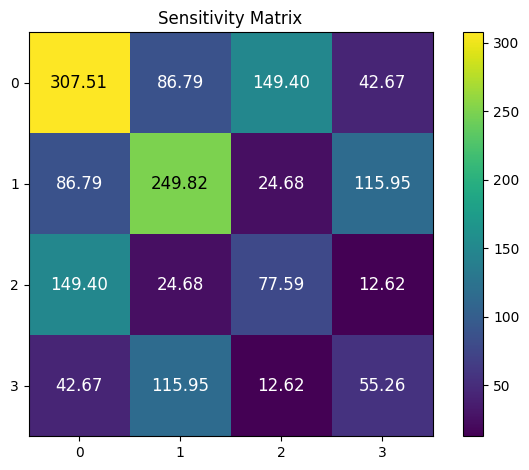

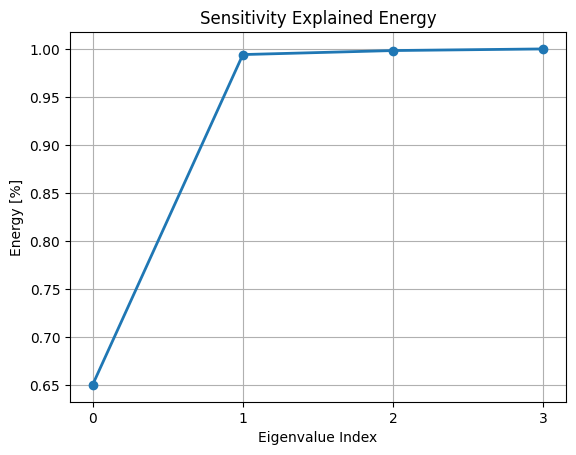

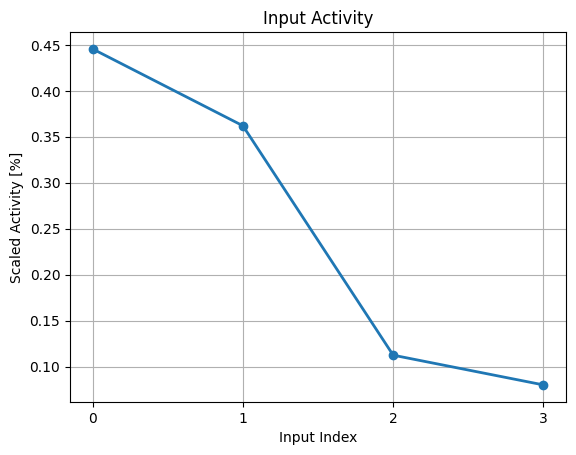

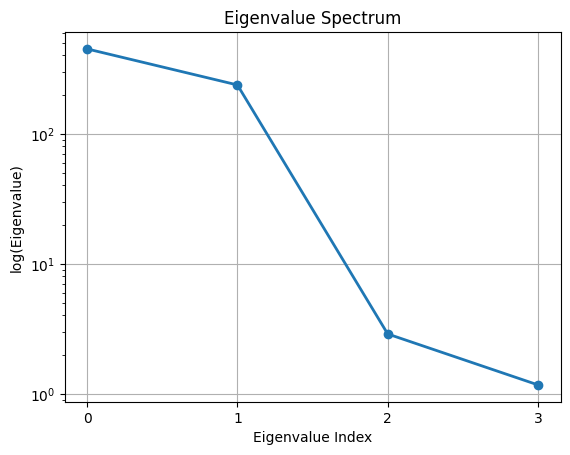

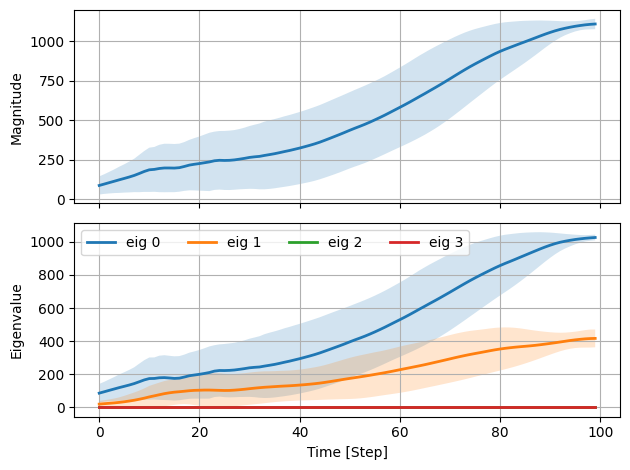

In [4]:
# plot logs
plot_matrix(C, "Sensitivity Matrix")
plot_1d(explained_energy, "Sensitivity Explained Energy", "Eigenvalue Index", "Energy [%]")
plot_1d(input_activity, "Input Activity", "Input Index", "Scaled Activity [%]")
plot_semilogy(eigvals, "Eigenvalue Spectrum", "Eigenvalue Index", "log(Eigenvalue)")
plot_multistep_sensitivity(C_traj, eig_traj, log=False)